# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils import vector_transforms

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [84]:
epochs = 12
n_train = 100000
epsilon = 0.01
train = False

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x_sim = simulator.sample(n_train)
x_sim_tensor = torch.from_numpy(x_sim)
train_dataset = TensorDataset(x_sim_tensor, x_sim_tensor)

12:50 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.4 -1.4]
12:50 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [0.97989899]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


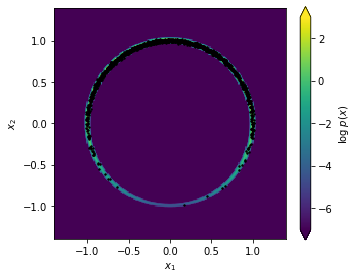

In [4]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_sim[::50,0], x_sim[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

print("Integral over density =", np.sum(np.exp(logp_grid) * pixel_size))

1.0000930850098504

## Set up models

### Manifold flow

In [46]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

15:44 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
15:44 manifold_flow.flows.base       DEBUG   Created standard flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 <B
15:44 manifold_flow.training.trainer INFO    Training on CPU with single precision
15:44 manifold_flow.training.trainer DEBUG   Initialising training data
15:44 manifold_flow.training.trainer DEBUG   Setting up optimizer
15:44 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
15:44 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
15:44 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
15:44 manifold_flow.training.trainer DEBUG   Beginning main training loop
15:44 manifold_flow.training.trainer DEBUG   Training epoch 1 / 4
15:44 manifold_flow.training.trainer DEBUG     Learning rate: 0.001
15:45 manifold_flow.training.trainer INFO    Epoch   1: train los

(array([1.20340276, 1.20291645, 1.20292685, 1.20289809]),
 array([1.2031293 , 1.20327217, 1.20317768, 1.2031722 ]))

In [ ]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(mf)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 3,
        forward_kwargs={"mode":"projection"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[100., 0.1],
        epochs=epochs // 3,
        forward_kwargs={"mode":"mf"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 3,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mf.state_dict(), "../data/models/mf_1_spherical_gaussian_1_2_0.010.pt")
else:
    mf.load_state_dict(torch.load("../data/models/mf_1_spherical_gaussian_1_2_0.010.pt"))

### PIE

In [7]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

13:23 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
13:23 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
13:23 manifold_flow.training.trainer INFO    Training on CPU with single precision
13:23 manifold_flow.training.trainer DEBUG   Initialising training data
13:23 manifold_flow.training.trainer DEBUG   Setting up optimizer
13:23 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
13:23 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
13:23 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
13:23 manifold_flow.training.trainer DEBUG   Beginning main training loop
13:23 manifold_flow.training.trainer DEBUG   Training epoch 1 / 12
13:23 manifold_flow.training.trainer DEBUG     Learning rate: 0.001
13:24 manifold_flow.training.trainer INFO    Epoch   1: train lo

(array([ 5.93488216e+03,  2.51858625e+01,  4.99203524e+01,  6.36202417e+01,
         7.72513592e+01,  5.78661190e+01,  4.01251104e+01,  2.93416373e+01,
         1.35737875e+01,  6.17260819e+00,  1.80984950e+00, -1.92719718e-01]),
 array([ 16.21243673,  47.51820895,   5.98933511, 110.17487866,
         70.99299747,  83.30112271,  17.74026494,  21.77191319,
          9.06426881,   3.61291135,   1.98477712,  -0.84812755]))

In [89]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(pie)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"pie"}
    )
    torch.save(pie.state_dict(), "../data/models/pie_1_spherical_gaussian_1_2_0.010.pt")
else:
    pie.load_state_dict(torch.load("../data/models/pie_1_spherical_gaussian_1_2_0.010.pt"))

### Slice of PIE

In [8]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

slice_of_pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

14:16 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
14:16 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
14:16 manifold_flow.training.trainer INFO    Training on CPU with single precision
14:16 manifold_flow.training.trainer DEBUG   Initialising training data
14:16 manifold_flow.training.trainer DEBUG   Setting up optimizer
14:16 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
14:16 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
14:16 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
14:16 manifold_flow.training.trainer DEBUG   Beginning main training loop
14:16 manifold_flow.training.trainer DEBUG   Training epoch 1 / 4
14:16 manifold_flow.training.trainer DEBUG     Learning rate: 0.001
14:18 manifold_flow.training.trainer INFO    Epoch   1: train los

(array([-4.56845531, -4.56855519, -4.56878636, -4.56861585]),
 array([-4.56842957, -4.56842958, -4.56842954, -4.56842957]))

In [90]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(slice_of_pie)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[10.],
        epochs=epochs // 3,
        forward_kwargs={"mode": "projection"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[10., 0.01],
        epochs=epochs // 3,
        forward_kwargs={"mode": "slice"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 3,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode": "slice"}
    )
    torch.save(slice_of_pie.state_dict(), "../data/models/slice_1_spherical_gaussian_1_2_0.010.pt")
else:
    slice_of_pie.load_state_dict(torch.load("../data/models/slice_1_spherical_gaussian_1_2_0.010.pt"))

### Standard flow

In [9]:
transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
sf = Flow(
    data_dim=2,
    transform=transform
)

14:46 manifold_flow.flows.base       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 7.9 <B
14:46 manifold_flow.training.trainer INFO    Training on CPU with single precision
14:46 manifold_flow.training.trainer DEBUG   Initialising training data
14:46 manifold_flow.training.trainer DEBUG   Setting up optimizer
14:46 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
14:46 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
14:46 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
14:46 manifold_flow.training.trainer DEBUG   Beginning main training loop
14:46 manifold_flow.training.trainer DEBUG   Training epoch 1 / 12
14:46 manifold_flow.training.trainer DEBUG     Learning rate: 0.001
14:47 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.90910 (nll:  1.909)
14:47 manifold_flow.training.trainer INFO               val. loss   1.87421 (nll:  1.874)
14:

(array([1.9091042 , 1.88287079, 1.87315587, 1.87301552, 1.86921962,
        1.8664033 , 1.86115909, 1.86055222, 1.85802576, 1.8566352 ,
        1.8544098 , 1.85338535]),
 array([1.87420891, 1.8648986 , 1.87583464, 1.88761102, 1.87627046,
        1.85601257, 1.85796118, 1.87288582, 1.85712349, 1.85366155,
        1.85364543, 1.85216228]))

In [91]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(sf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf.state_dict(), "../data/models/flow_1_spherical_gaussian_1_2_0.010.pt")
else:
    sf.load_state_dict(torch.load("../data/models/flow_1_spherical_gaussian_1_2_0.010.pt"))

## Evaluate the generative performance

### Sample

In [92]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()
x_gen_pie_full = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [93]:
def generative_metrics(x_gen, logp_min=-100., d_max=1., summary_fn=np.mean):
    logp_gen = simulator.log_density(x_gen)
    logp_gen[(~np.isfinite(logp_gen)) + (logp_gen<logp_min)] = logp_min
    logp_summary = summary_fn(logp_gen)
    
    d_gen = np.abs(np.sum(x_gen**2, axis=1)**0.5 - 1)
    d_gen[(~np.isfinite(d_gen)) + (d_gen>d_max)] = d_max
    d_summary = summary_fn(d_gen)
    
    return logp_summary, d_summary

In [94]:
logp_gen_sf, d_gen_sf = generative_metrics(x_gen_sf)
logp_gen_mf, d_gen_mf = generative_metrics(x_gen_mf)
logp_gen_pie, d_gen_pie = generative_metrics(x_gen_pie)
logp_gen_pie_full, d_gen_pie_full = generative_metrics(x_gen_pie_full)

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow:      {:>6.1f}".format(logp_gen_sf))
print("  PIE (sampling all): {:>6.1f}".format(logp_gen_pie_full))
print("  PIE (sampling M):   {:>6.1f}".format(logp_gen_pie))
print("  Manifold flow:      {:>6.1f}".format(logp_gen_mf))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow:      {:>6.4f}".format(d_gen_sf))
print("  PIE (sampling all): {:>6.4f}".format(d_gen_pie))
print("  PIE (sampling M):   {:>6.4f}".format(d_gen_pie))
print("  Manifold flow:      {:>6.4f}".format(d_gen_mf))


10:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [0.9794977  0.63257635]
10:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [0.57342911], z_eps = [0.16600537]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))
10:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.0043463  -0.04005496]
10:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.18145091], z_eps = [0.0051446]
10:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [0.9470937 0.2959249]
10:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [0.30284464], z_eps = [-0.00775099]
10:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-0.26917633  0.9174165 ]
10:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [1.85619354], z

Mean true log likelihood of samples generated from flows (higher is better):
  Standard flow:       -86.7
  PIE (sampling all):  -14.9
  PIE (sampling M):    -10.0
  Manifold flow:         1.9
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
  Standard flow:      0.5559
  PIE (sampling all): 0.0485
  PIE (sampling M):   0.0485
  Manifold flow:      0.0044


### Visualize generated samples

10:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5 -1.5]
10:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [1.12132034]


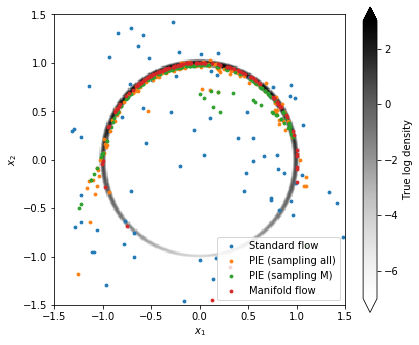

In [95]:
skip = 8
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.5,1.5,-1.5,1.5),
    origin="lower",
    cmap="Greys",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")

plt.scatter(x_gen_sf[::skip,0], x_gen_sf[::skip,1], s=8., c="C0", label="Standard flow")
plt.scatter(x_gen_pie_full[::skip,0], x_gen_pie_full[::skip,1], s=8., c="C1", label="PIE (sampling all)")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie[::skip,1], s=8., c="C2", label="PIE (sampling M)")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf[::skip,1], s=8., c="C3", label="Manifold flow")

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")

plt.tight_layout()
plt.savefig("../figures/spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Calculate log likelihood on grid

In [63]:
res = 200
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))

# learned_logp_grid_mf = mf.log_prob(x_grid_tensor, mode="mf").detach().numpy().reshape((res, res))
# learned_logp_grid_slice_of_pie = slice_of_pie.log_prob(x_grid_tensor, mode="slice").detach().numpy().reshape((res, res))

logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


09:19 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5 -1.5]
09:19 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [1.12132034]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


### Calculate along manifold

In [52]:
def likelihood_along_manifold(model, mode, zmin=-5., zmax=5., n_samples=100, epsilon=0.05):
    # Sample
    u = torch.linspace(zmin, zmax, n_samples).view(-1,1)
    x = model.sample(n=n_samples, u=u).detach().numpy()
    
    # Interpolate
    x_interpol = [x[0]]
    for x, x_prev in zip(x[:-1], x[1:]):
        distance = np.linalg.norm(x-x_prev)
        if distance > epsilon:
            n_insert = int(distance / epsilon)
            for frac in np.linspace(0., 1., n_insert + 2)[1:-1]:
                x_interpol.append(x_prev + frac * (x-x_prev))
        x_interpol.append(x)
    x_interpol.append(x)
    x_interpol = np.array(x_interpol)
    print(x_interpol.shape)

    # Evaluate likelihood
    log_probs = model.log_prob(torch.FloatTensor(x_interpol), mode=mode).detach().numpy()

    # Return
    return x_interpol, log_probs

In [61]:
x_manifold_mf, learned_logp_manifold_mf = likelihood_along_manifold(mf, "mf")
x_manifold_slice, learned_logp_manifold_slice = likelihood_along_manifold(slice_of_pie, "slice")


(307, 2)
(234, 2)


### Plot likelihoods

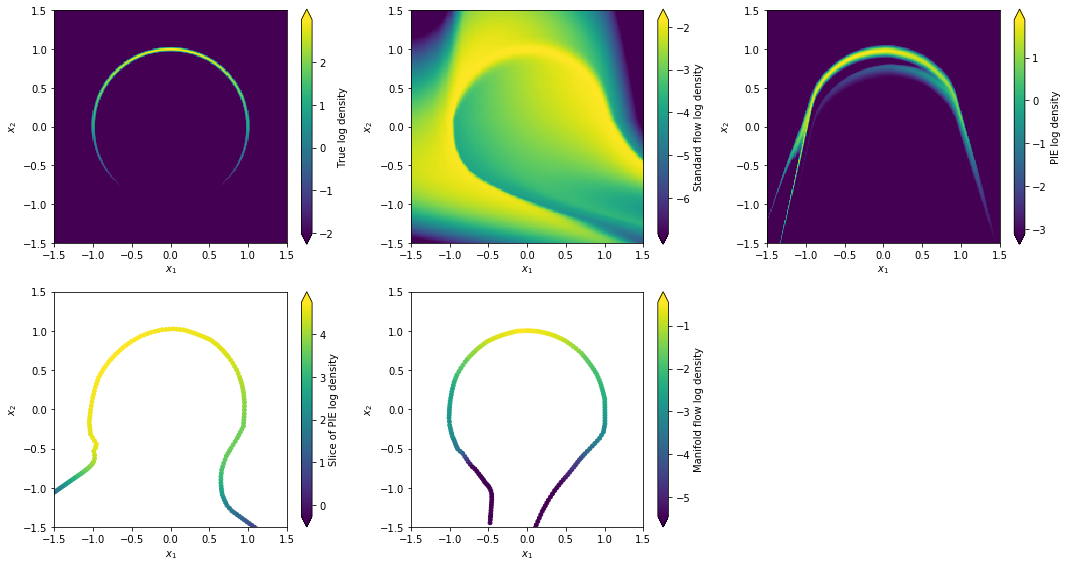

In [64]:
fig = plt.figure(figsize=(15,8))

for i, (label, logp, x) in enumerate(zip(
    ["True log density", "Standard flow log density", "PIE log density",
     "Slice of PIE log density", "Manifold flow log density"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_pie,
     learned_logp_manifold_slice, learned_logp_manifold_mf],
    [None, None, None,
     x_manifold_slice, x_manifold_mf]
     )):
    ax = plt.subplot(2,3,i+1)

    zmin, zmax = np.max(logp) - 5., np.max(logp)

    if x is None:
        pcm = plt.imshow(
            np.clip(logp, zmin, zmax),
            extent=(-1.5, 1.5, -1.5, 1.5),
            origin="lower",
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
            interpolation='nearest'
        )
    else:
        pcm = plt.scatter(
            x[:,0], x[:,1],
            c=np.clip(logp, zmin, zmax),
            s=15.,
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
        )
    cb = plt.colorbar(pcm, extend="both")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    
plt.tight_layout()
plt.savefig("../figures/spherical_gaussian_2d_log_prob.pdf", dpi=600)


## Plot reconstruction performance

In [96]:
x_in = SphericalGaussianSimulator(1,2,epsilon=10*epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

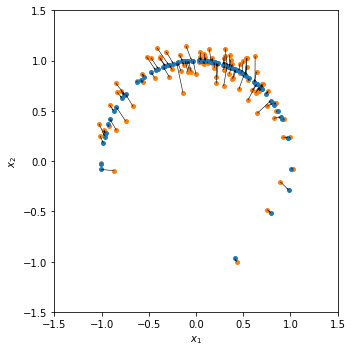

In [97]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("../figures/spherical_gaussian_2d_mf_reco.pdf")


## Model anatomy

In [65]:
model = mf

In [66]:
res = 50
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x = torch.FloatTensor(x)
x.requires_grad = True


In [67]:
# Encode
u, h_manifold, h_orthogonal, log_det_outer, log_det_inner = model._encode(x)

# Decode
x_reco, _, _, inv_jacobian_outer = model._decode(u, mode="mf")
_, inv_log_det_inner, inv_log_det_outer, _ = model._decode(u, mode="slice")

# inv_jacobian_outer is dx / du, but still need to restrict this to the manifold latents
inv_jacobian_outer = inv_jacobian_outer[:, :, : model.latent_dim]
# And finally calculate log det (J^T J)
jtj = torch.bmm(torch.transpose(inv_jacobian_outer, -2, -1), inv_jacobian_outer)
mf_log_det_outer = - 0.5 * torch.slogdet(jtj)[1]

log_prob_latent = model.manifold_latent_distribution._log_prob(u, context=None)

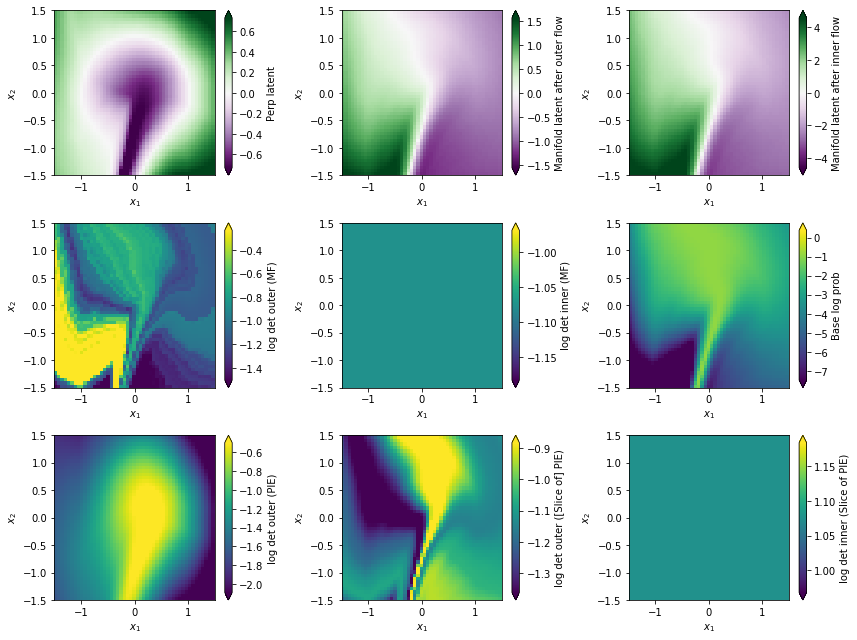

In [68]:
fig = plt.figure(figsize=(12,9))

for panel, (label, quantity, diverging) in enumerate(zip(
    ["Perp latent", "Manifold latent after outer flow", "Manifold latent after inner flow",
     "log det outer (MF)", "log det inner (MF)", "Base log prob",
     "log det outer (PIE)", "log det outer ([Slice of] PIE)", "log det inner (Slice of PIE)"],
    [h_orthogonal, h_manifold, u,
     mf_log_det_outer, - log_det_inner, log_prob_latent,
     log_det_outer, - inv_log_det_outer, - inv_log_det_inner],
    [True, True, True, False, False, False, False, False, False]
)):
    ax = plt.subplot(3,3,panel+1)
    
    quantity_ = quantity.detach().numpy()
    quantity_ = quantity_.flatten() + np.zeros((res**2))
    
    if diverging:
        zmin, zmax = - 2. * np.std(quantity_), 2. * np.std(quantity_)
    else:
        zmin, zmax = np.mean(quantity_) - 1.5 * np.std(quantity_), np.mean(quantity_) + 1.5 * np.std(quantity_)

    pcm = plt.pcolormesh(
        x_range, y_range,
        np.clip(np.clip(quantity_, zmin, zmax).reshape(res, res), zmin, zmax),
        cmap="PRGn" if diverging else "viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
    )
    cb = plt.colorbar(pcm, extend="both")
    # plt.scatter(x_gen_mf[::10,0], x_gen_mf[::10,1], s=3., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    plt.tight_layout()

plt.savefig("../figures/spherical_gaussian_2d_mf_anatomy.pdf")